<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-comparison-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Results and Comparisons</strong>
</h1>

In [1]:
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Imports
</h1>


In [2]:
# Suppress user and future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json


# repository imports
from models import def_models
from utils import utils_funcs

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GPU: Making Results Shine!
</h1>

In [3]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-alzheimer-100.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>The Data</strong>
</h1>

**Load The Data**

In [4]:
batch_size = 64
height = 224
width = 224

train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

**Alzheimer Severity Data**

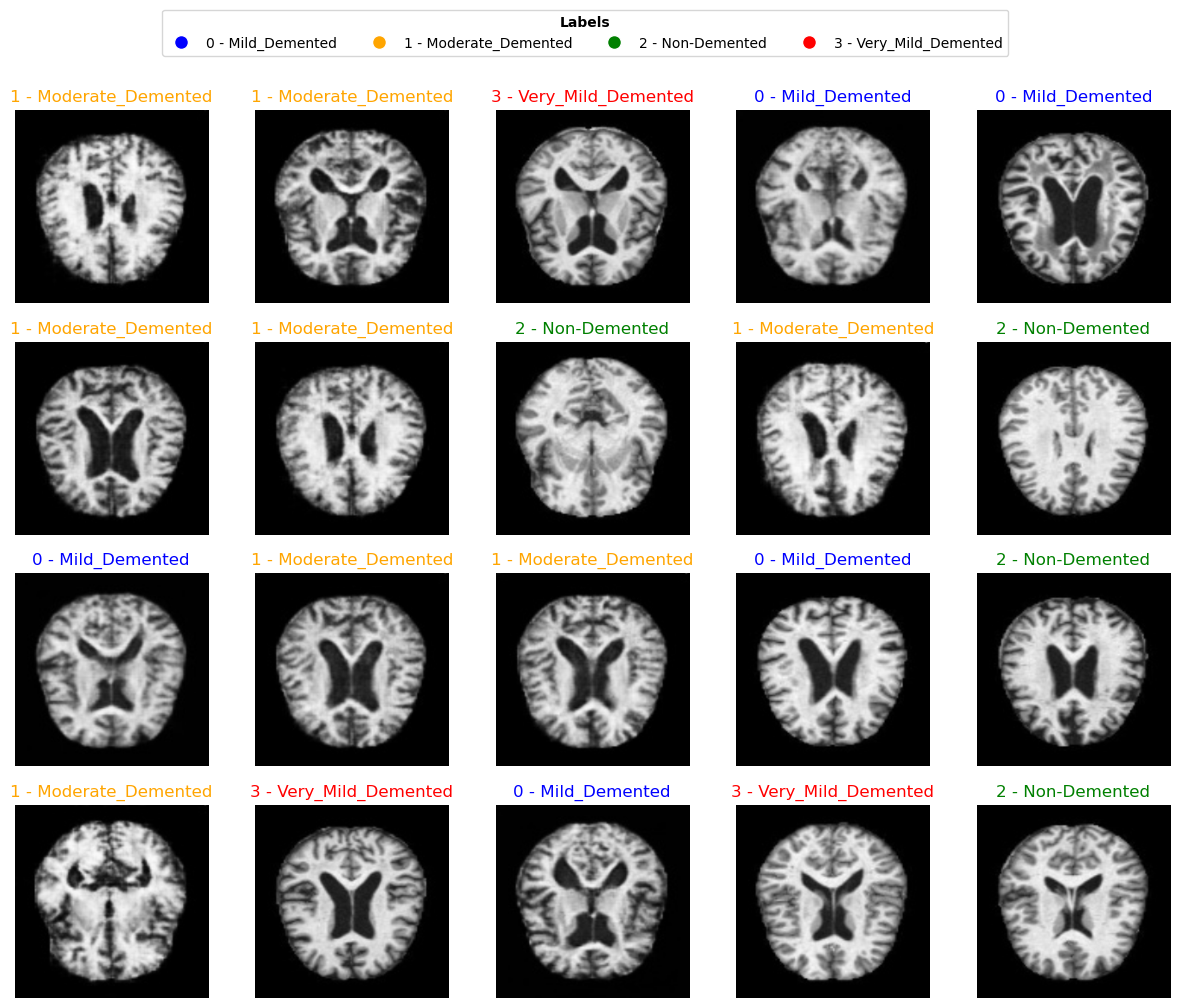

In [5]:
utils_funcs.plot_random_images(train_set,20)

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/icons8-kawaii-dinosaur-48.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>DinoV2 Fine Tuned</strong>
</h1>


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Preprocessing of data
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [20]:
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# make the model
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

# retrieve the fined-tuned model
model_path = './checkpoints/DINO_v2_FT_151506_05102024/DINO_v2_FT_173045_05102024_train_0.0364_val_0.1293.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [7]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

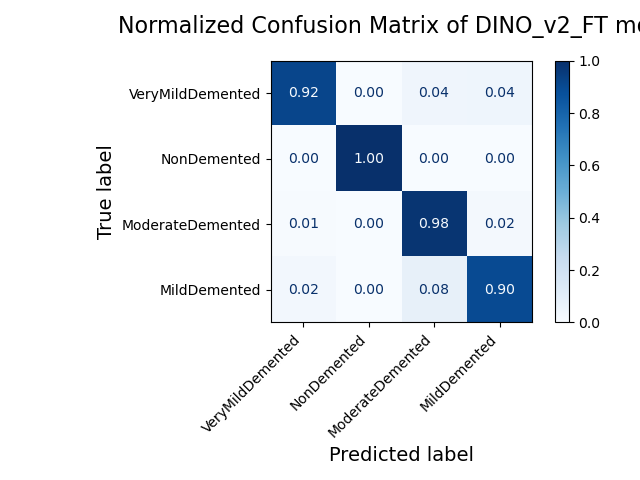

In [8]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

**Visualize T-SNE**

In [9]:
# utils_funcs.visualize_dino_tsne(model.dino_backbone, dino_validationloader, device, perplexity=10, learning_rate=1000)
# #TODO: make it so we only need to bring the image here

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

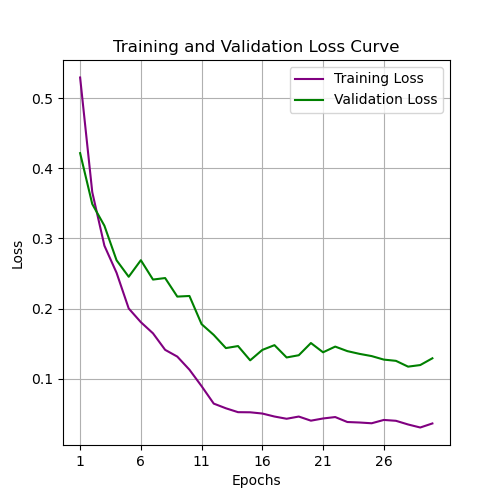

In [10]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

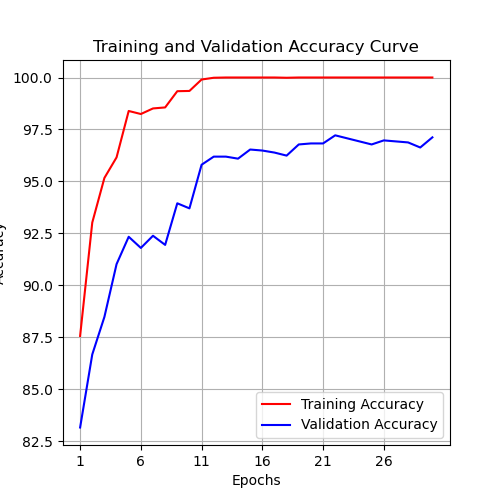

In [11]:
utils_funcs.load_and_display_image(model_name,'plot_accuracy_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [21]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 94.058%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Model2 Fine Tuned</strong>
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Preprocessing of data
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [13]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

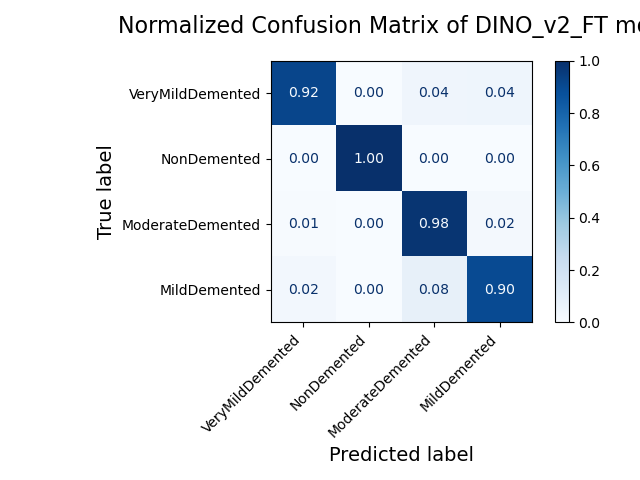

In [14]:
utils_funcs.load_and_display_image(model_name,'confusion_matrix')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

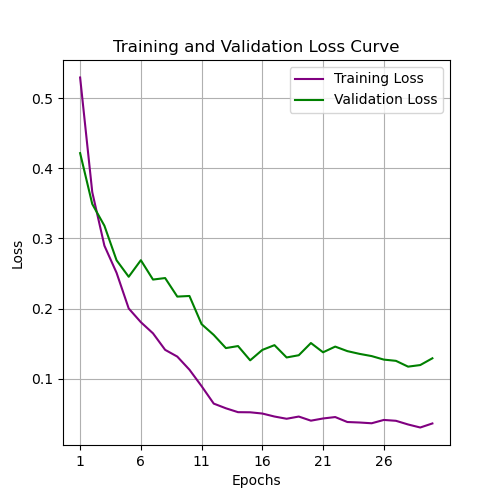

In [15]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

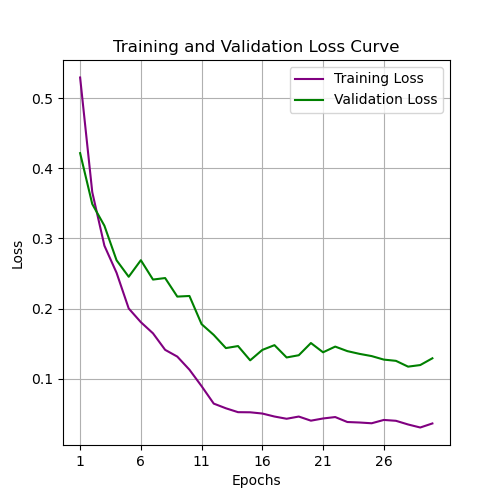

In [16]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [17]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 90.930%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>

<h1 style="display: flex; align-items: center;">
    <img src="../assets/icons/deep-learning_2.png" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>Model3 Fine Tuned</strong>
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-process-100.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Preprocessing of data
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Retrieve fined-tuned Model
</h1>

In [6]:
# Initialize input and output sizes
input_channels = 3
output_channels = 4

# Load a pre-trained EfficientNet-B4 model
efficientnet_b4_model = torchvision.models.efficientnet_b4(pretrained=True)

# Create an instance of your modified EfficientNet-B4 model
model = def_models.Efficientnet_B4_FT(efficientnet_backbone=efficientnet_b4_model, output_channels=output_channels).to(device)

# retrieve the fined-tuned model
model_path = './checkpoints/Efficientnet_B4_FT_125244_05102024\Efficientnet_B4_FT_134657_05102024_train_0.5698_val_0.4993.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Architecture statistics
</h1>

In [7]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

model  Efficientnet_B4_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]           1,152
 

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-matrix-60.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Confusion Matrix
</h1>

In [8]:
# utils_funcs.load_and_display_image(model_name,'confusion_matrix')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Training Curve of the best fined-tuned model
</h1>

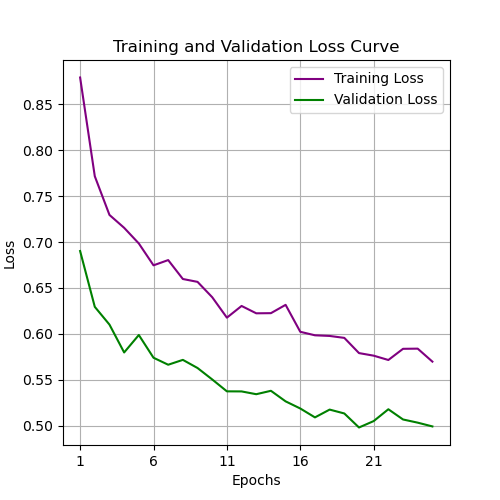

In [9]:
utils_funcs.load_and_display_image(model_name,'plot_loss_curve')

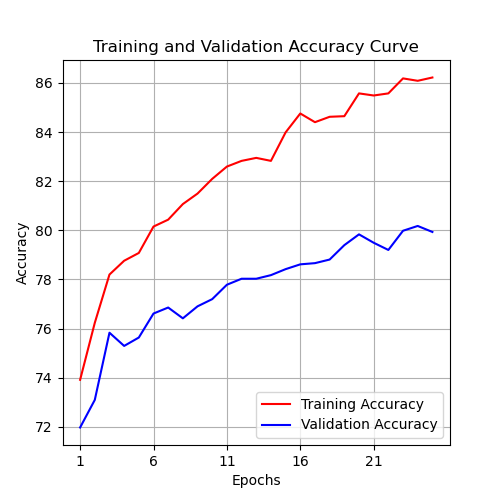

In [10]:
utils_funcs.load_and_display_image(model_name,'plot_accuracy_curve')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-accuracy-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Accuracy
</h1>

In [11]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 22.987%


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-source-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    GradCAM
</h1>

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchcam.methods import GradCAM
import gc

def overlay_gradcam(img, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply a color map
    heatmap = np.float32(heatmap) / 255  # Normalize heatmap
    img = np.float32(img) / 255  # Normalize the original image
    cam_image = heatmap + img  # Overlay heatmap on the original image
    cam_image = cam_image / np.max(cam_image)  # Normalize to range [0, 1]
    return np.uint8(255 * cam_image)  # Convert back to [0, 255] range

testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Set the device and model to evaluation mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
gc.collect()

# Ensure requires_grad = True for all model parameters
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
model.eval()

# Specify the target layer for Grad-CAM
target_layer = model.efficientnet_backbone.features[-1]

# Initialize Grad-CAM with the target layer
gradcam = GradCAM(model, target_layer=target_layer)

# Get the first image and label from the test loader
img, label = next(iter(testloader))
img, label = img.to(device), label.to(device)

# Forward pass to get the output
output = model(img)
_, predicted = torch.max(output, 1)

# Generate Grad-CAM heatmap for the predicted class
try:
    gradcam_output = gradcam(class_idx=predicted.item(), scores=output)  # Pass output scores
except Exception as e:
    print(f"Error generating Grad-CAM output: {e}")

# Convert the image to numpy format for display
img_np = img.cpu().squeeze().numpy().transpose(1, 2, 0)
img_np = img_np * 0.5 + 0.5  # Unnormalize if necessary

# Overlay Grad-CAM heatmap on the image
cam = gradcam_output[0].cpu().numpy()  # Get the first (and only) heatmap from the output
cam_image = overlay_gradcam(img_np, cam)  # Pass the correct variable to the overlay function

# Plot the original and Grad-CAM images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f"Original Image\nTrue: {label.item()}, Pred: {predicted.item()}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM\nTrue: {label.item()}, Pred: {predicted.item()}")
plt.axis('off')

plt.tight_layout()
plt.show()


Error generating Grad-CAM output: 'bool' object is not callable


NameError: name 'gradcam_output' is not defined

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    DinoV2 under attack - FGSM,PGD
</h1>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-graph-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Adversial Training Curve
</h1>